In [126]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation

In [136]:
# Setting the number of spacial and time increments
Nr = 100
Nt = 100


# Setting the start time and end time
t_0 = 0
t_T = 1

# Setting the start and end of the rod
R_0 = 0
R_Nr = 1

# Finding the step sizes for space and time
dr = (R_Nr - R_0)/Nr
dt = (t_T - t_0)/Nt

# Overwrite rod start to deal with 1/r term
R_0 = dr

# Setting the proportion of the length which will be sword (always centred)
# for eg right now its the middle third
sword_prop = 1/10
sword_temp = 500 # Initial temp of the sword
water_temp = 25 # Initial temp of the water


sword_edge = int(sword_prop * Nr)

# making a linearly spaced r array
r = np.linspace(R_0, R_Nr, Nr)
# r = np.ones(Nr)

# The diffusivity constant - we can make this a step function of x and make a "diffusivity array"..
# ...similar to how ive defined the initial condition below
D_sword = 11.72
D_water = 0.143  # values from: [https://en.wikipedia.org/wiki/Thermal_diffusivity]

In [137]:
# Defining the sword temperature as a function
# ...this means we can vary the heat distribution across the swords width later if we want
# ...right now its just uniformly "sword_temp"
def sword_func(sword_temp, sword):
    
    return sword*0 + sword_temp


# Defining the initial condition
def Ics(sword_edge, sword_prop, sword_temp, water_temp):
    
    # Making an array of zeros of the right size and updating the area the sword inhabits using our sword temp function
    Ics = np.zeros(Nr)
    Ics += water_temp
    Ics[:sword_edge] = sword_func(sword_temp, Ics[:sword_edge]) 
    
    return Ics

In [138]:
U = np.zeros([Nr, Nt])
Ics = Ics(sword_edge, sword_prop, sword_temp, water_temp)

U[:, 0] = Ics

print(r)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.  ]


In [139]:
# This bit is backward euler with neumann (no-flux) conditions, from the last slide of the week2 live lecture

# Pre-defining an array of Diffusion values
def diffus_array(D_water, D_sword, sword_edge, dt, dr):
    
    D = np.zeros(Nr)
    
    D += D_water
    
    D[:sword_edge] = D_sword
    
    return D

D = diffus_array(D_water, D_sword, sword_edge, dt, dr)

# Setting the value of our constant C
C = dt/(2*dr**2)

# To form our A, we make an empty array first
A = np.zeros([Nr, Nr])

# We define the middle of A, row by row
for m in range(2, Nr-2):
    
    
#     A[m, m-2:m+3] = [-C*D[m-1], 2*C*(dr/r[m])*D[m-1], C*(D[m-1] + D[m+1]) + 1, -2*C*(dr/r[m])*D[m+1], -C*D[m+1]]
    A[m, m-2:m+3] = [-C*D[m-1], 2*C*(dr/r[m-1])*D[m-1], C*(D[m-1] + D[m+1]) + 1, -2*C*(dr/r[m+1])*D[m+1], -C*D[m+1]]

# ...then defining the first and last rows, according to our boundary conditions
# we are assuming U_-2 = U_2 (ask ben next week)

# A[0, 0:3] = [2*C*D[1] + 1, 0, -2*C*D[1]]
# A[1, 1:5] = [C*2*(dr/r[1])*D[2], C*D[2] + 1, -C*2*(dr/r[1])*D[2], -C*D[2]]
# A[-2, -4:] = [-C*D[-3], 2*C*(dr/r[-2])*D[-3], C*D[-3] + 1, -2*C*(dr/r[-2])*D[-3]]
# A[-1, -3:] = [-2*C*D[-2], 0, 2*C*D[-2] + 1]
A[0, 0:3] = [2*C*D[1] + 1, 0, -2*C*D[1]]
A[1, 0:4] = [C*2*(dr/r[0])*D[1], C*D[1] + 1, -C*2*(dr/r[2])*D[1], -C*D[1]]
A[-2, -4:] = [-C*D[-1], 2*C*(dr/r[-3])*D[-1], C*D[-1] + 1, -2*C*(dr/r[-1])*D[-1]]
A[-1, -3:] = [-2*C*D[-1], 0, 2*C*D[-1] + 1]

# Finding the inverse of A
Ainv = linalg.inv(A)

print(A)

# ...and implementing backward euler
for n in range(Nt - 1):
    
    U[:, n+1] = np.matmul(Ainv, U[:, n])

# We end up with all our discretised data in the matrix U
### IMPORTANT --- it's coded so each ROW of U represents the temperature across the rod at a fixed time.

[[ 1.17300000e+03  0.00000000e+00 -1.17200000e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.17200000e+03  5.87000000e+02 -3.90666667e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.86000000e+02  5.86000000e+02  1.17300000e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.53000000e+01
  -1.44444444e-01 -7.15000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.45918367e-01
   8.15000000e+00 -1.43000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.43000000e+01
   0.00000000e+00  1.53000000e+01]]


In [140]:
# defining Nt linearly spaced times
T = np.linspace(t_0, t_T, Nt)

# Finding the area under the curve at each timestep:
# We set up a vector
Curve_Area = np.ones(Nt)

# And use the trapezium method to get the area under the curve for each time
for n in range(Nt):

    Curve_Area[n] = np.trapz(U[:, n], r)

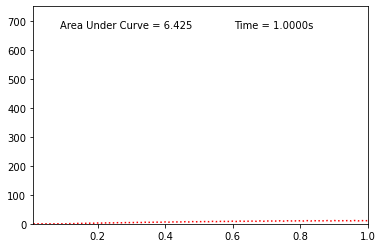

In [141]:
# We make an animation of how to temperature changes throughout the system with time

# Setting up animation plots
fig, ax = plt.subplots()
ax.axis([R_0, R_Nr, 0, max(sword_temp, water_temp)*1.5]) # Setting axis limits -- the xlims are the ends of the rod

# Making a template to update with values for our time and area-under-the-curve counters
area_template = 'Area Under Curve = %.3f'
time_template = 'Time = %.4fs'

# Setting the initial text strings, specifying placement in the graph
area_text= ax.text(0.08, 0.9, '', transform = ax.transAxes)
time_text = ax.text(0.6, 0.9, '', transform = ax.transAxes)

# We define a function which updates our plot each timestep
def animate(n):
    
    l.set_data(r, U[:, n]) # Updates the temperature vector each timestep

    # Updates our area amd time captions each timestep
    time_text.set_text(time_template % T[n]) 
    area_text.set_text(area_template % Curve_Area[n])
    
    return l, time_text, area_text

# Plotting the new data (in red dots)
l, = ax.plot([],[],':r')

# Creating the animation
ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt)

# and displaying it
from IPython.display import HTML
HTML(ani2.to_jshtml())